## CubixBox BAO Reconstruction Script

In [4]:
import os
os.environ["MPICH_GPU_SUPPORT_ENABLED"] = "0"
import glob
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 12
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from cosmoprimo.fiducial import DESI, AbacusSummit
from mockfactory import utils, DistanceToRedshift, Catalog
from pyrecon import MultiGridReconstruction, IterativeFFTReconstruction, IterativeFFTParticleReconstruction, utils, setup_logging
from pypower import CatalogFFTPower, PowerSpectrumMultipoles
from pycorr import TwoPointCorrelationFunction, TwoPointEstimator, project_to_multipoles, project_to_wp, utils, setup_logging

setup_logging()

In [5]:
def get_distorted_positions(positions, q_perp, q_para, los='z'):
    """Given a set of comoving galaxy positions in cartesian
    coordinates, return the positions distorted by the 
    Alcock-Pacynski effect"""
    positions_ap = np.copy(positions)
    factor_x = q_para if los == 'x' else q_perp
    factor_y = q_para if los == 'y' else q_perp
    factor_z = q_para if los == 'z' else q_perp
    positions_ap[:, 0] /= factor_x
    positions_ap[:, 1] /= factor_y
    positions_ap[:, 2] /= factor_z
    return positions_ap

def get_distorted_box(boxsize, q_perp, q_para, los='z'):
    """Distort the dimensions of a cubic box with the
    Alcock-Pacynski effect"""
    factor_x = q_para if los == 'x' else q_perp
    factor_y = q_para if los == 'y' else q_perp
    factor_z = q_para if los == 'z' else q_perp
    boxsize_ap = [boxsize/factor_x, boxsize/factor_y, boxsize/factor_z]
    return boxsize_ap

def wrap_box(cat, boxsize):
        for var in 'xyz':
            cat[var] = cat[var]%boxsize - boxsize/2
            if f'{var}_rsd' in cat.columns(): 
                cat[f'{var}_rsd'] = cat[f'{var}_rsd']%boxsize - boxsize/2

def get_recon_bias(tracer='LRG', grid_cosmo=None): # need update for different cosmologies
    if tracer.startswith('BGS'):
        f=  0.682
        bias = {'000': 1.5, '001': 1.7, '002': 1.6, '003': 1.6, '004': 1.8}
    elif tracer.startswith('LRG+ELG'):
        bias = {'000': 1.6, '001': 1.7, '002': 1.6, '003': 1.6, '004': 1.8}
    elif tracer.startswith('LRG'):
        f =  0.834
        bias = {'000': 2.0, '001': 2.1, '002': 1.9, '003': 1.9, '004': 2.2}
    elif tracer.startswith('ELG'):
        f= 0.9
        bias = {'000': 1.2, '001': 1.3, '002': 1.2, '003': 1.2, '004': 1.4}
    elif tracer.startswith('QSO'):
        f= 0.928
        bias = {'000': 2.1, '001': 2.3, '002': 2.1, '003': 2.1, '004': 2.4}
    else:
        raise ValueError('unknown tracer {}'.format(tracer))
    if grid_cosmo is None:
        bias = bias['000']
    else:
        bias = bias[grid_cosmo]
    return f, bias

def run_reconstruction(Reconstruction, positions, f, bias, boxsize=None, nmesh=None, cellsize=20., smoothing_radius=15, convention='recsym', dtype='f8'):
    data_positions = positions
    recon = Reconstruction(f=f, bias=bias, boxsize=boxsize, nmesh=nmesh, cellsize=cellsize, los='local', positions=data_positions, boxpad=1.2, position_type = 'xyz', dtype=dtype)
    recon.assign_data(data_positions)
    recon.set_density_contrast(smoothing_radius=smoothing_radius)
    recon.run()
    field = 'rsd'
    if type(recon) is IterativeFFTParticleReconstruction:
        data_positions_rec = recon.read_shifted_positions('data', field =field, dtype='f8')
    else:
        data_positions_rec = recon.read_shifted_positions(data_positions, field=field, dtype='f8')
    return data_positions_rec

In [6]:
redshift= 0.5
mock_cosmo = AbacusSummit(2)
# mock_cosmo = DESI()

for file in glob.glob('/global/cfs/cdirs/desi/users/arocher/Y3/AbacusBox/LRG/cosmo_2/z0.500/AbacusSummit_base_c002_ph004/catalog_LRG_z0.500_SHOD_kibo-v1_v0.1_PIP.fits'):
    cat = Catalog.read(file)
    print(cat.columns)
    print(cat['z'])
    Hz = mock_cosmo.H0*mock_cosmo.efunc(redshift)
    # z_rsd = z + dv*(1+redshift)/Hz
    print(cat['z'] + cat['vz']*(1+redshift)/Hz) 
    print(cat['z_rsd'])

<bound method BaseCatalog.columns of Catalog(csize=5600555, size=5600555, columns=['x', 'y', 'z', 'vx', 'vy', 'vz', 'Rs', 'Rh', 'c', 'Mh', 'log10_Mh', 'Vrms', 'row_id', 'Central', 'x_rsd', 'y_rsd', 'z_rsd'])>
[-904.42285 -533.476   -430.8039  ...  180.94388 -230.884    437.67752]
[-898.74866 -535.6433  -428.29608 ...  177.67068 -221.54051  445.45258]
[1099.1394  1465.1633  1570.7705  ...  178.88898 1774.9818   442.55872]


In [ ]:
mock_cosmo = AbacusSummit(2)
fid_cosmo = DESI()
tracer = 'LRG'
redshift= 0.5

boxsize = 2000
nmesh=512

for file in glob.glob('/global/cfs/cdirs/desi/users/arocher/Y3/AbacusBox/LRG/cosmo_2/z0.500/AbacusSummit_base_c002_ph*/catalog_LRG_z0.500_SHOD_kibo-v1_v0.1_PIP.fits'):
# for file in glob.glob('/global/cfs/cdirs/desi/users/arocher/Y3/AbacusBox/LRG/cosmo_2/z0.500/AbacusSummit_base_c002_ph003/catalog_LRG_z0.500_SHOD_kibo-v1_v0.1_PIP.fits'):
    cat = Catalog.read(file)
    wrap_box(cat, 2000)
    los='z'
    for grid_cosmo in ['002', '000']:
        boxsize = 2000
        cosmo = AbacusSummit(2) if grid_cosmo == '002' else DESI()
        Hz = cosmo.H0*cosmo.efunc(redshift)
        cat['z_rsd'] = cat['z'] + cat['vz']*(1+redshift)/Hz
        data_positions = 0
        data_positions = np.c_[cat['x'], cat['y'], cat['z_rsd']]
        data_positions = data_positions%boxsize-boxsize/2.0
        if grid_cosmo == '000':
            print('position distorted')
            q_perp = mock_cosmo.comoving_angular_distance(redshift) / fid_cosmo.comoving_angular_distance(redshift)
            q_para = fid_cosmo.efunc(redshift) / mock_cosmo.efunc(redshift)
            data_positions = get_distorted_positions(positions=data_positions, los=los, q_perp=q_perp, q_para=q_para)
            boxsize = np.array(get_distorted_box(boxsize=boxsize, q_perp=q_perp, q_para=q_para, los=los))
            for i in range(3):
                data_positions.T[i] = data_positions.T[i]%boxsize[i]-boxsize[i]/2.0
                # data_positions = data_positions%boxsize-boxsize/2.0
        # compute the 2pcf
        for recon in [False, True]:
            smu_edges = (np.linspace(0., 200, 201), np.linspace(-1., 1., 201))
            kedges = {'min': 0., 'step': 0.001}
            if recon == False:
                correlation_root = os.path.join(file.split('/catalog')[0], f'allcounts_c{grid_cosmo}'+file.split('/catalog')[1]).replace('.fits','.npy')
                if not os.path.exists(correlation_root):
                    result = 0
                    result = TwoPointCorrelationFunction('smu', smu_edges, data_positions1=data_positions.T, boxsize=boxsize, engine='corrfunc', nthreads=256, los=los)
                    result.save(os.path.join(file.split('/catalog')[0], f'allcounts_c{grid_cosmo}'+file.split('/catalog')[1]).replace('.fits','.npy'))
                pk_root = os.path.join(file.split('/catalog')[0], f'pk_c{grid_cosmo}'+file.split('/catalog')[1]).replace('.fits','.npy')
                if not os.path.exists(pk_root):
                    result = 0
                    result = CatalogFFTPower(data_positions1=data_positions.T, edges=kedges, ells=(0, 2), boxsize=boxsize, nmesh=nmesh, resampler='tsc', interlacing=2, los='z', position_type='xyz')
                    result.save(os.path.join(file.split('/catalog')[0], f'pk_c{grid_cosmo}'+file.split('/catalog')[1]).replace('.fits','.npy'))

            elif recon == True:
                # add rescontruction here
                print('reconstruction here')
                f, bias = get_recon_bias(tracer = 'LRG', grid_cosmo = grid_cosmo)
                Reconstruction = {'IFFT': IterativeFFTReconstruction, 'IFFTP': IterativeFFTParticleReconstruction, 'MG': MultiGridReconstruction}['IFFT']
                data_positions_rec = run_reconstruction(Reconstruction, data_positions, f, bias, boxsize=boxsize, nmesh= nmesh)
                data_positions_rec = data_positions_rec%boxsize-boxsize/2.0
                correlation_rec_root = os.path.join(file.split('/catalog')[0], f'allcounts_rec_c{grid_cosmo}'+file.split('/catalog')[1]).replace('.fits','.npy')
                if not os.path.exists(correlation_rec_root):
                    result = 0
                    result_rec = TwoPointCorrelationFunction('smu', smu_edges, data_positions1=data_positions_rec.T, boxsize=boxsize, engine='corrfunc', nthreads=256, los=los)
                    result_rec.save(correlation_rec_root)
                pk_rec_root = os.path.join(file.split('/catalog')[0], f'pk_rec_c{grid_cosmo}'+file.split('/catalog')[1]).replace('.fits','.npy')
                if not os.path.exists(pk_rec_root):
                    result = 0
                    result_rec = CatalogFFTPower(data_positions1=data_positions_rec.T, edges=kedges, ells=(0, 2), boxsize=boxsize, nmesh=nmesh, resampler='tsc', interlacing=2, los='z', position_type='xyz')
                    result_rec.save(os.path.join(file.split('/catalog')[0], f'pk_rec_c{grid_cosmo}'+file.split('/catalog')[1]).replace('.fits','.npy'))

[001135.09]  02-12 07:17  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[001135.09]  02-12 07:17  TwoPointCorrelationFunction  INFO     Running auto-correlation.
[001135.09]  02-12 07:17  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[001162.07]  02-12 07:17  TwoPointCorrelationFunction  INFO     Analytically computing two-point counts R1R2.
[001162.07]  02-12 07:17  TwoPointCorrelationFunction  INFO     Correlation function computed in elapsed time 26.98 s.
[001162.07]  02-12 07:17  NaturalTwoPointEstimator     INFO     Saving /global/cfs/cdirs/desi/users/arocher/Y3/AbacusBox/LRG/cosmo_2/z0.500/AbacusSummit_base_c002_ph004/allcounts_c002_LRG_z0.500_SHOD_kibo-v1_v0.1_PIP.npy.
[001162.26]  02-12 07:17  CatalogFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[512 512 512], boxsize=[2000. 2000. 2000.], boxcenter=[-9.15527344e-05  5.79833984e-04 -6.71386719e-04], dtype=

[004550.96]  02-12 08:14  TwoPointEstimator            INFO     Loading /global/cfs/cdirs/desi/users/arocher/Y3/AbacusBox/LRG/cosmo_2/z0.500/AbacusSummit_base_c002_ph000/allcounts_c002_LRG_z0.500_SHOD_kibo-v1_v0.1_PIP.npy.
[004550.98]  02-12 08:14  TwoPointEstimator            INFO     Loading /global/cfs/cdirs/desi/users/arocher/Y3/AbacusBox/LRG/cosmo_2/z0.500/AbacusSummit_base_c002_ph000/allcounts_rec_c002_LRG_z0.500_SHOD_kibo-v1_v0.1_PIP.npy.
[004550.99]  02-12 08:14  TwoPointEstimator            INFO     Loading /global/cfs/cdirs/desi/users/arocher/Y3/AbacusBox/LRG/cosmo_2/z0.500/AbacusSummit_base_c002_ph001/allcounts_c002_LRG_z0.500_SHOD_kibo-v1_v0.1_PIP.npy.
[004550.99]  02-12 08:14  TwoPointEstimator            INFO     Loading /global/cfs/cdirs/desi/users/arocher/Y3/AbacusBox/LRG/cosmo_2/z0.500/AbacusSummit_base_c002_ph001/allcounts_rec_c002_LRG_z0.500_SHOD_kibo-v1_v0.1_PIP.npy.
[004550.99]  02-12 08:14  TwoPointEstimator            INFO     Loading /global/cfs/cdirs/desi/users

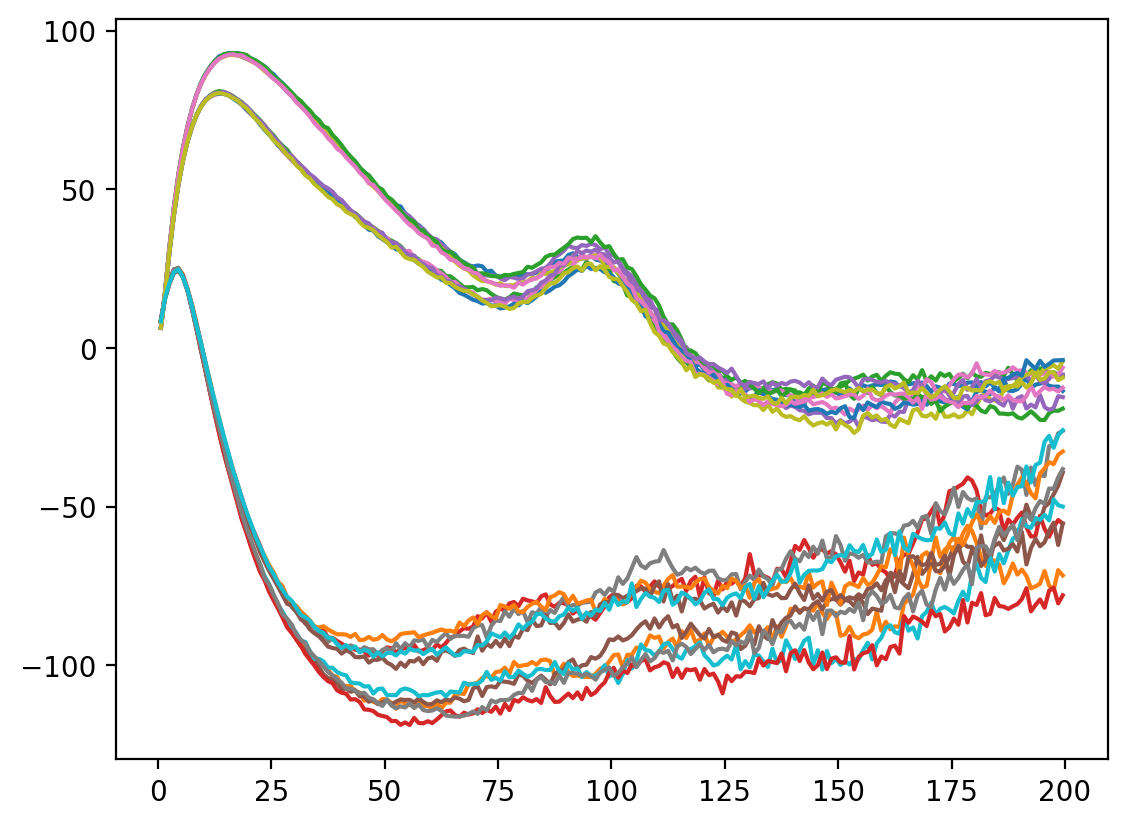

In [44]:
for i in range(5):
    basedir = f'/global/cfs/cdirs/desi/users/arocher/Y3/AbacusBox/LRG/cosmo_2/z0.500/AbacusSummit_base_c002_ph00{i}'
    result = TwoPointCorrelationFunction.load(basedir+'/allcounts_c002_LRG_z0.500_SHOD_kibo-v1_v0.1_PIP.npy')
    s, xi = project_to_multipoles(result, ells=[0,2])
    plt.plot(s, s**2*xi[0], label = 'pre-recon')
    plt.plot(s, s**2*xi[1], label = 'pre-recon')

    # basedir = '/global/cfs/cdirs/desi/users/arocher/Y3/AbacusBox/LRG/cosmo_2/z0.500/AbacusSummit_base_c002_ph004'
    result = TwoPointCorrelationFunction.load(basedir+'/allcounts_rec_c002_LRG_z0.500_SHOD_kibo-v1_v0.1_PIP.npy')
    s, xi = project_to_multipoles(result, ells=[0,2])
    plt.plot(s, s**2*xi[0], label = 'post-recon')
    plt.plot(s, s**2*xi[1], label = 'post-recon')
# plt.legend()

[000340.64]  02-12 06:40  PowerSpectrumMultipoles      INFO     Loading /global/cfs/cdirs/desi/users/arocher/Y3/AbacusBox/LRG/cosmo_2/z0.500/AbacusSummit_base_c002_ph003/pk_c002_LRG_z0.500_SHOD_kibo-v1_v0.1_PIP.npy.
[000340.66]  02-12 06:40  PowerSpectrumMultipoles      INFO     Loading /global/cfs/cdirs/desi/users/arocher/Y3/AbacusBox/LRG/cosmo_2/z0.500/AbacusSummit_base_c002_ph003/pk_rec_c002_LRG_z0.500_SHOD_kibo-v1_v0.1_PIP.npy.


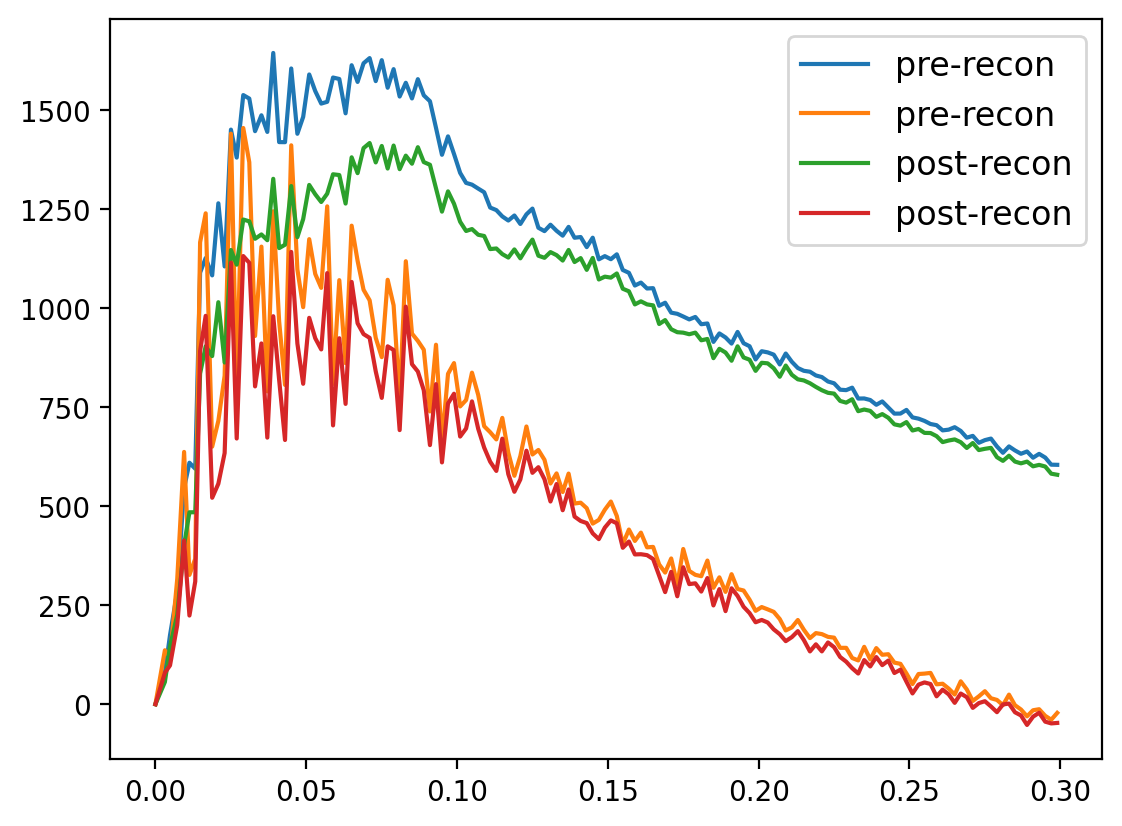

In [23]:
basedir = '/global/cfs/cdirs/desi/users/arocher/Y3/AbacusBox/LRG/cosmo_2/z0.500/AbacusSummit_base_c002_ph003'
result = PowerSpectrumMultipoles.load(basedir+'/pk_c002_LRG_z0.500_SHOD_kibo-v1_v0.1_PIP.npy')
result.select((0.0,0.3,0.002))
pk = np.real(result.get_power())
k = result.kavg
plt.plot(k, k*pk[0], label = 'pre-recon')
plt.plot(k, k*pk[1], label = 'pre-recon')

result = PowerSpectrumMultipoles.load(basedir+'/pk_rec_c002_LRG_z0.500_SHOD_kibo-v1_v0.1_PIP.npy')
result.select((0.0,0.3,0.002))
pk = np.real(result.get_power())
k = result.kavg
plt.plot(k, k*pk[0], label = 'post-recon')
plt.plot(k, k*pk[1], label = 'post-recon')
plt.legend()

[000272.29]  02-17 00:58  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000272.29]  02-17 00:58  TwoPointCorrelationFunction  INFO     Running auto-correlation.
[000272.29]  02-17 00:58  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000272.99]  02-17 00:58  TwoPointCorrelationFunction  INFO     Analytically computing two-point counts R1R2.
[000272.99]  02-17 00:58  TwoPointCorrelationFunction  INFO     Correlation function computed in elapsed time 0.70 s.
[000273.01]  02-17 00:58  IterativeFFTReconstruction   INFO     Using mesh with nmesh=[100 100 100], boxsize=[2000. 2000. 2000.], boxcenter=[ 2.44140625e-03 -3.44848633e-03  1.00000363e+03].
[000273.02]  02-17 00:58  IterativeFFTReconstruction   INFO     Slab 0 ~ 4194304 / 219064.
[000273.16]  02-17 00:58  IterativeFFTReconstruction   INFO     Painted 219064 out of 219064 objects to mesh.
[000273.20]  02-17 00:58  IterativeFFTReconstructio

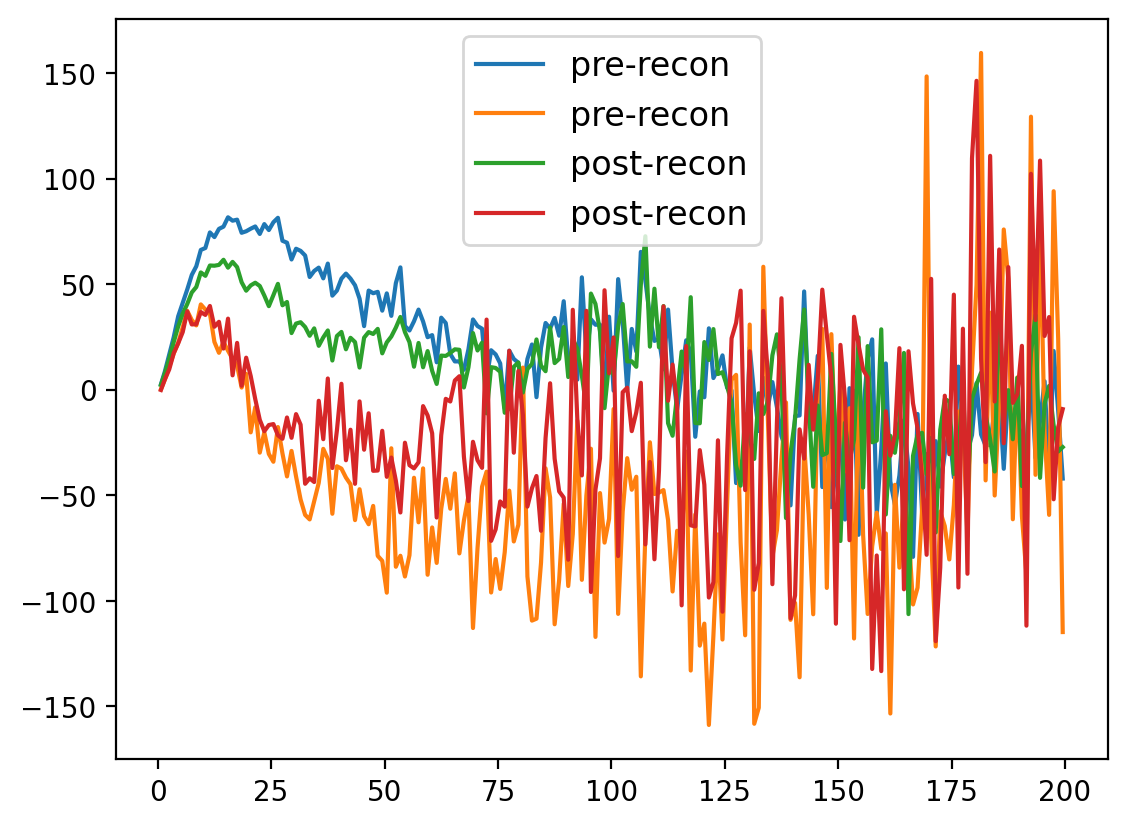

In [ ]:
smuedges  = (np.linspace(0., 200, 201), np.linspace(-1., 1., 201))
basedir = f'/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/QSO/obs_z0.8-1.1/AbacusSummit_base_c000_ph001'
fn = basedir+f'/catalog_rsd_xi2d_QSO_z0.8-1.1_velbias_B_s_mockcov.fits'
catalog = Catalog.read(fn)
for sysmodel in ['standard']:
# for sysmodel in ['standard', 'dv-obs']:
    if sysmodel == 'standard':
        positions = [catalog['x'],catalog['y'], catalog['z']]
    elif sysmodel == 'dv-obs':
        positions = [catalog['x'],catalog['y'], catalog['z_dv']]
    result_rec = TwoPointCorrelationFunction('smu', smuedges, data_positions1=positions, boxsize=2000., engine='corrfunc', nthreads=256, los='z')
    s, xi = project_to_multipoles(result_rec, ells=[0,2])
    
    plt.plot(s, s**2*xi[0], label = 'pre-recon')
    plt.plot(s, s**2*xi[1], label = 'pre-recon')

    Reconstruction = {'IFFT': IterativeFFTReconstruction, 'IFFTP': IterativeFFTParticleReconstruction, 'MG': MultiGridReconstruction}['IFFT']
    f, bias = get_recon_bias(tracer = 'LRG', grid_cosmo = '000')
    positions = run_reconstruction(Reconstruction, positions, f, bias, boxsize=2000.)
    result_rec = TwoPointCorrelationFunction('smu', smuedges, data_positions1=positions, boxsize=2000., engine='corrfunc', nthreads=256, los='z')
    s, xi = project_to_multipoles(result_rec, ells=[0,2])
    plt.plot(s, s**2*xi[0], label = 'post-recon')
    plt.plot(s, s**2*xi[1], label = 'post-recon')
    plt.legend()